# Importing libraries

Importing  tensorflow and basic data science libraries.


In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing  import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Scraping and preprocessing data

Scraping data from IBGE, organizing columns and rows, converting dates into datetime (since they were originally hardcoded in portuguese).


In [0]:
# Import csv from IBGE website
df = pd.read_csv('https://sidra.ibge.gov.br/geratabela?format=us.csv&name=tabela3416.csv&terr=N&rank=-&query=t/3416/n1/all/v/564/p/all/c11046/40311/d/v564%201/l/v,c11046,t%2Bp',
                 skiprows=3, index_col=1)
# Drops unwanted column
df = df.drop(['Unnamed: 0'], axis=1) 
# Drops metadata at the end of the dataframe
df = df[:-10] 
# Converts dates into datetime (they were originally in hardcoded Portuguese)
df['date'] = df.index
new = df["date"].str.split(" ", n = 1, expand = True) 
df["Month"]= new[0] 
df["Year"]= new[1] 
df.drop(columns =["date"], inplace = True) 
daysofweek = {
    'janeiro':'01',
    'fevereiro': '02',
    'março': '03',
    'abril': '04',
    'maio': '05',
    'junho': '06',
    'julho': '07',
    'agosto': '08',
    'setembro': '09',
    'outubro': '10',
    'novembro': '11',
    'dezembro': '12'
}
for key, value in daysofweek.items():
  df = df.replace(key,value)
df['Date'] = df['Month'] + '/'+ df['Year']
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
df = df.drop(['Month', 'Year', 'Date'], axis=1)
# Renaming column
df.columns = ['Retail Sales Index - Brazil - 2014=100']

Text(0.5, 1.0, 'Retail Sales Index - Brazil - 2014=100')

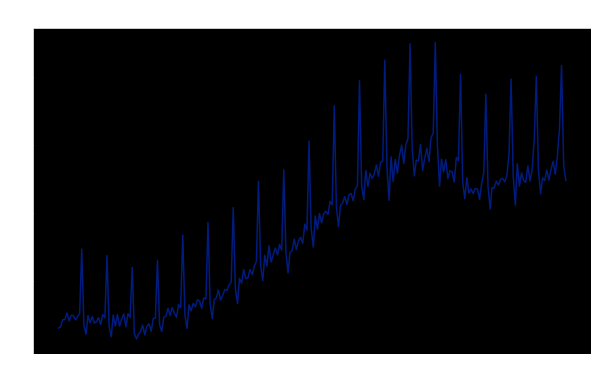

In [96]:
# Plotting Time Series
plt.style.use('seaborn-dark-palette')
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111) 
ax.plot(df['Retail Sales Index - Brazil - 2014=100'])
plt.title('Retail Sales Index - Brazil - 2014=100', fontsize=20)

# Splitting and creating a gridsearch pipeline

In [0]:
# Creating a 24 months test size 
test_size = 24
# Length of Batches, 12 months = 1 year to capture seasonality
length = 12
test_ind = len(df) - test_size
# Spliting the data
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]
# Scaling the Data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

# Time series generator, creating batches
generator = TimeseriesGenerator(scaled_train, scaled_train,
                                length=length, batch_size=1)

n_features = 1 # Just one feature, Sales Index

In [0]:
# Creating method for model gridsearch

def train_test(h_units, h_dropout, h_optimizer):
  model = Sequential()
  model.add(LSTM(h_units, activation='relu',input_shape=(length,n_features), return_sequences=True))
  model.add(Dropout(h_dropout))
  model.add(LSTM(64, activation='relu',input_shape=(length,n_features)))
  model.add(Dropout(h_dropout))
  model.add(Dense(1))
  model.compile(optimizer=h_optimizer,loss='mse')

  # Creates an early stop mechanism
  early_stop = EarlyStopping(monitor='val_loss',patience=3)
  validation_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                            length=length, batch_size=1)
  # Fitting the model
  model.fit(generator,epochs=200,
            validation_data=validation_generator,
            callbacks=[early_stop], verbose =0)
  
  test_predictions = []

  # Storing losses
  losses = pd.DataFrame(model.history.history)

  # Updating current_batch with predictions, so the model predicts based on previous predicted values
  first_eval_batch = scaled_train[-length:]
  current_batch = first_eval_batch.reshape((1,length,n_features))

  for i in range(len(test)):
      current_pred = model.predict(current_batch)[0]
      test_predictions.append(current_pred)
      current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

  # Inverse transforming predictions and adding them to a df with the test set
  true_predictions = scaler.inverse_transform(test_predictions)
  real_vs_pred = test
  real_vs_pred['Predictions'] = true_predictions
  rmse = np.sqrt(mean_squared_error(real_vs_pred.iloc[:,0], real_vs_pred.iloc[:,1]))
  
  # Returns prediction RMSE (Root Mean Square Error)
  return rmse, losses, real_vs_pred

In [8]:
# Gridsearching hyperparameters
unitlist = [128, 172, 256]
droplist = [0.1, 0.2, 0.3]
optimizerlist = ['adam', 'rmsprop']

grid_rmse = {}
grid_losses = {}
grid_real_pred = {}
for unit in unitlist:
  for drop in droplist:
    for optim in optimizerlist:
      model_rmse, losses_df, real_vs_pred = train_test(unit, drop, optim)
      current_model = '{} units, {} dropout, {} optimizer, {} epochs'.format(unit,drop,optim, len(losses_df))
      grid_rmse[current_model] = model_rmse
      grid_losses[current_model] = losses_df
      grid_real_pred[current_model] = real_vs_pred
      nr_of_models = str(len(unitlist)*len(droplist)*len(optimizerlist))
      print(str(len(grid_rmse.items())) + " out of " + nr_of_models)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1 out of 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2 out of 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3 out of 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4 out of 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5 out of 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6 out of 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7 out of 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8 out of 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9 out of 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


10 out of 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


11 out of 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


12 out of 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


13 out of 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


14 out of 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


15 out of 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


16 out of 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


17 out of 18
18 out of 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [98]:
grid_rmse_df = pd.DataFrame.from_dict(grid_rmse.items())
best_model = grid_rmse_df.sort_values(by=1)[0].iloc[0]
print(best_model)

256 units, 0.3 dropout, adam optimizer, 17 epochs


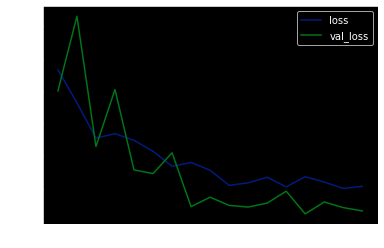

In [90]:
plt.style.use('seaborn-dark-palette')
grid_losses[best_model].plot()

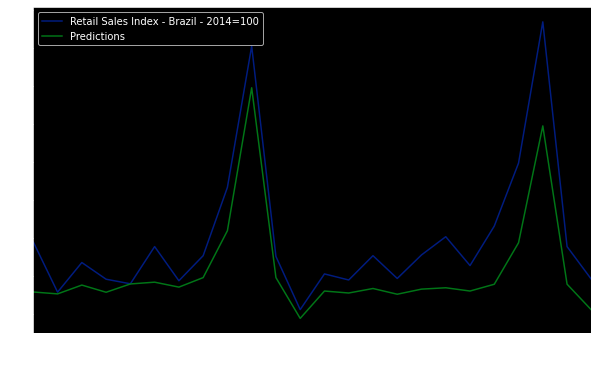

In [95]:
plt.style.use('seaborn-dark-palette')
grid_real_pred[best_model].plot(figsize = (10,6))

In [99]:
grid_real_pred[best_model]

,Retail Sales Index - Brazil - 2014=100,Predictions
Date,,
2018-03-01,94.5,87.918804
2018-04-01,87.9,87.669054
2018-05-01,91.8,88.830770
2018-06-01,89.6,87.883944
2018-07-01,89.0,88.978450
2018-08-01,93.9,89.212475
2018-09-01,89.4,88.560936
2018-10-01,92.7,89.813415
2018-11-01,101.7,95.991993


# FORECASTING

Forecasting into the unknown future (12 months)

In [14]:
# Scaling the whole df
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)
length = 12
# Generator
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data,
                                length=length, batch_size=1)
# Best model:
# 256 units, 0.3 dropout, adam optimizer, 17 epochs
                          
model = Sequential()
model.add(LSTM(256, activation='relu',input_shape=(length,n_features), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, activation='relu',input_shape=(length,n_features)))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

model.fit(generator, epochs=17)

# Forecasting the unknown future
forecast = []
periods = 12
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

# Updating batches with predicted values
for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

# Inverse transforming and indexing
forecast = scaler.inverse_transform(forecast)
forecast_index = pd.date_range(start='2020-03-01', periods=periods,
                               freq='MS')

# Merging forecast and index
forecast_df = pd.DataFrame(data=forecast, index=forecast_index,
                           columns=['Forecast'])

Epoch 1/17
230/230 [==============================] - 4s 19ms/step - loss: 0.0247
Epoch 2/17
230/230 [==============================] - 4s 19ms/step - loss: 0.0160
Epoch 3/17
230/230 [==============================] - 4s 19ms/step - loss: 0.0144
Epoch 4/17
230/230 [==============================] - 4s 19ms/step - loss: 0.0124
Epoch 5/17
230/230 [==============================] - 4s 19ms/step - loss: 0.0122
Epoch 6/17
230/230 [==============================] - 4s 19ms/step - loss: 0.0103
Epoch 7/17
230/230 [==============================] - 4s 19ms/step - loss: 0.0071
Epoch 8/17
230/230 [==============================] - 4s 19ms/step - loss: 0.0084
Epoch 9/17
230/230 [==============================] - 4s 19ms/step - loss: 0.0049
Epoch 10/17
230/230 [==============================] - 4s 19ms/step - loss: 0.0071
Epoch 11/17
230/230 [==============================] - 4s 19ms/step - loss: 0.0060
Epoch 12/17
230/230 [==============================] - 4s 19ms/step - loss: 0.0044
Epoch 13/17
2

(60.0, 130.0)

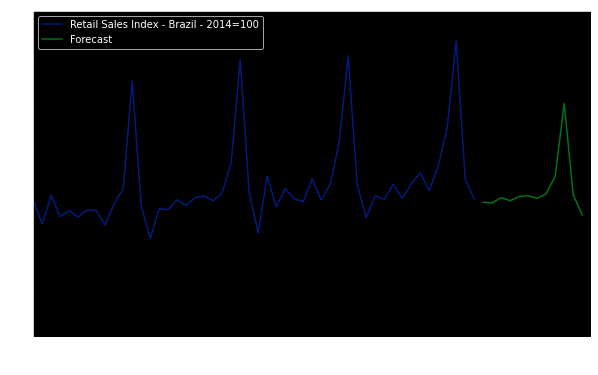

In [97]:
# Plotting
ax = df.plot(figsize=(10, 6))
forecast_df.plot(ax=ax, figsize=(10, 6))
plt.xlim('2016-01-01','2021-03-01')
plt.ylim(60,130)